<a href="https://colab.research.google.com/github/ruheyun/python_pytorch/blob/main/RNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
time_step = 10  # rnn 时序步长数
input_size = 1  # rnn 的输入维度
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_size = 64  # of rnn 隐藏单元个数
epochs = 100  # 总共训练次数
hidden_state = None  # 隐藏层状态

In [3]:
steps = np.linspace(0, np.pi*2, 256, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

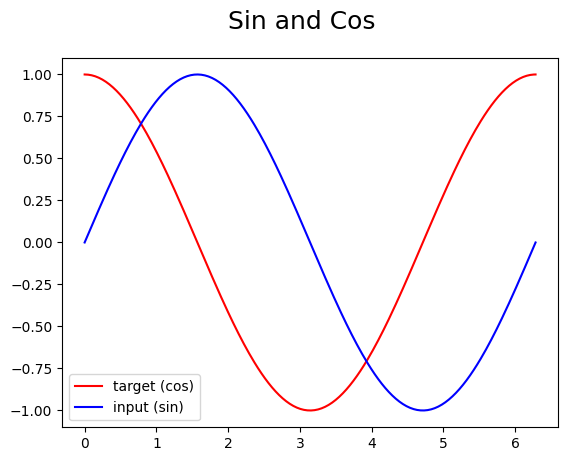

In [4]:
plt.figure(1)
plt.suptitle('Sin and Cos', fontsize='18')
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x, hidden_state):
        r_out, hidden_state = self.rnn(x, hidden_state)
        outs = []  # 保存所有的预测值
        for time_step in range(r_out.size(1)):  # 计算每一步长的预测值
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), hidden_state

EPOCHS: 19,Loss:0.334458


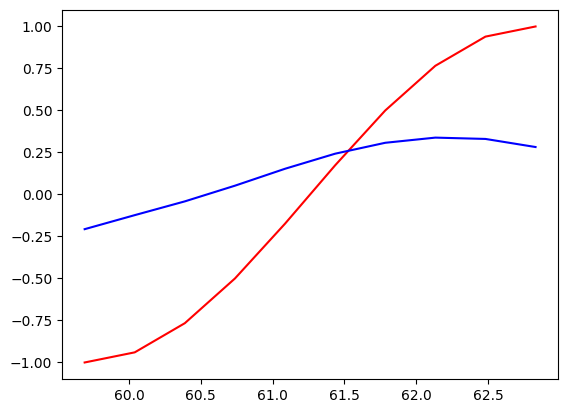

EPOCHS: 39,Loss:0.036158


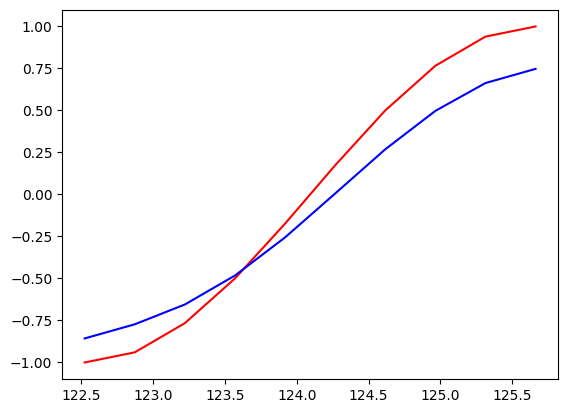

EPOCHS: 59,Loss:0.004877


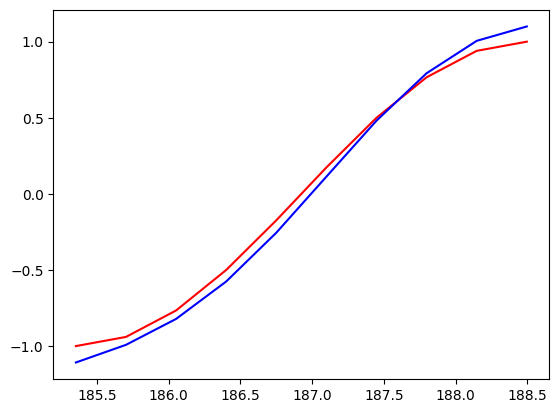

EPOCHS: 79,Loss:0.003229


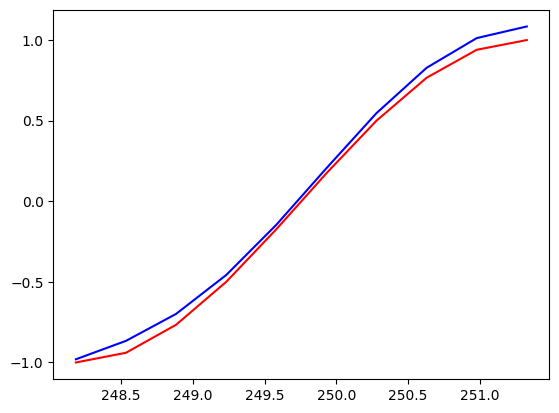

EPOCHS: 99,Loss:0.001416


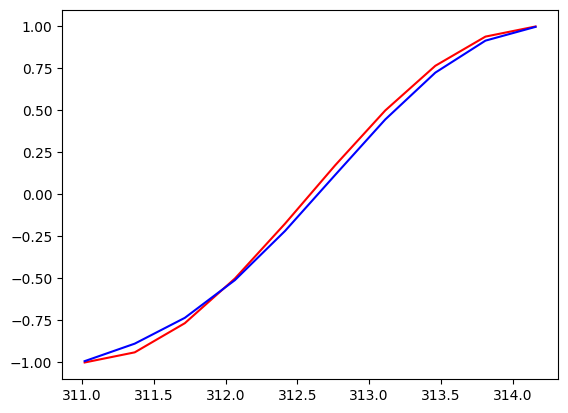

In [9]:
rnn = RNN().to(device)
optimizer = torch.optim.Adam(rnn.parameters())  # Adam优化，几乎不用调参
criterion = nn.MSELoss()  # 因为最终的结果是一个数值，所以损失函数用均方误差

plt.figure(2)
for step in range(epochs):
    rnn.train()
    start, end = step * np.pi, (step+1)*np.pi  # 一个时间周期
    steps = np.linspace(start, end, time_step, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis])  # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    x, y = x.to(device), y.to(device)
    prediction, hidden_state = rnn(x, hidden_state) # rnn output
    # 这一步非常重要
    hidden_state = hidden_state.detach()  # 重置隐藏层的状态, 切断和前一次迭代的链接
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      if (step+1) % 20 == 0:  # 每训练20个批次可视化一下效果，并打印一下loss
          print("EPOCHS: {},Loss:{:4f}".format(step, loss))
          plt.plot(steps, y_np.flatten(), 'r-')
          plt.plot(steps, prediction.flatten().cpu().numpy(), 'b-')
          plt.draw()
          plt.pause(0.01)